In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import keras
import os 
import random

In [2]:
data_dir = "data/10_food_classes_10_percent/"

for directory, folders, files in os.walk(data_dir): 
    print(f"There are {len(folders)} folders and {len(files)} files in '{directory}'")

There are 2 folders and 0 files in 'data/10_food_classes_10_percent/'
There are 10 folders and 0 files in 'data/10_food_classes_10_percent/test'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/chicken_curry'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/chicken_wings'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/fried_rice'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/grilled_salmon'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/hamburger'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/ice_cream'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/pizza'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/ramen'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/steak'
There are 0 folders and 250 files in 'data/10_food_classes_10_percent/test/sush

In [3]:
test_dir = "data/10_food_classes_10_percent/test/" 
train_dir = "data/10_food_classes_10_percent/train/"

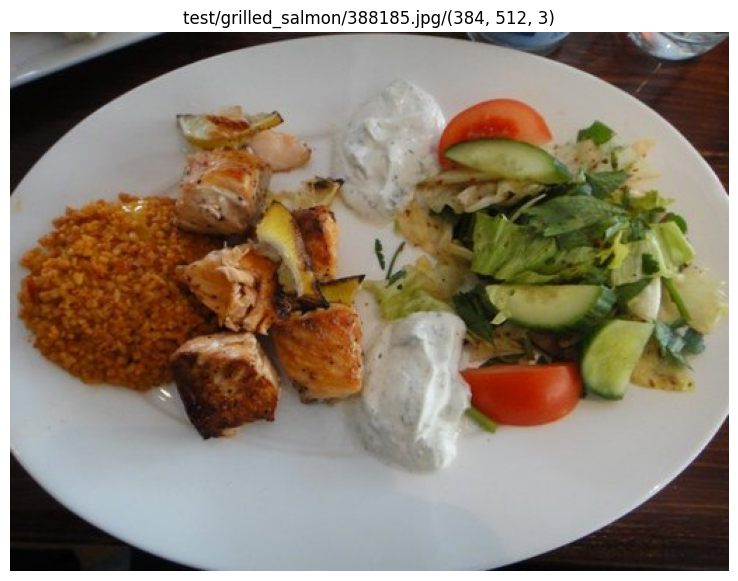

In [4]:
def view_random_image(dataset_dir): 
    rand_class = random.choice(os.listdir(dataset_dir)) 
    d_type_dir = os.path.join(dataset_dir, rand_class) 
    random_class = random.choice(os.listdir(d_type_dir)) 
    clas_path = os.path.join(d_type_dir, random_class) 
    rand_img = random.choice(os.listdir(clas_path)) 
    img_path = os.path.join(clas_path, rand_img)

    img = mpimg.imread(img_path) 

    plt.figure(figsize=(10, 7)) 
    plt.imshow(img)
    plt.title(f"{rand_class}/{random_class}/{rand_img}/{img.shape}")
    plt.axis("off")
    plt.show();

view_random_image(dataset_dir=data_dir)

In [5]:
# Create dataset 

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode="categorical", 
    shuffle=True, 
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode="categorical", 
    shuffle=True, 
    seed=42
)

class_names = train_ds.class_names

test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE) 
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

print(class_names)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [6]:
def build_efficientv2_model(variant, 
                            num_classess, 
                            base_trainable=False,
                            dropout=0.2,
                            lr=1e-3):

    model_name = f"EfficientNetV2{variant}"

    BaseModel = getattr(keras.applications, model_name) 

    EFFICIENTNETV2_SIZES = {
        "B0": (224, 224),
        "B1": (240, 240),
        "B2": (260, 260),
        "B3": (300, 300),
        "S":  (384, 384),
        "M":  (480, 480),
        "L":  (480, 480)
    }

    img_size = EFFICIENTNETV2_SIZES[variant] 

    base = BaseModel(
        include_top=False, 
        weights="imagenet", 
        input_shape=img_size+(3,), 
        pooling="avg"
    )

    base.trainable=False 
    inputs = keras.Input(shape=img_size+(3,)) 
    x = keras.applications.efficientnet_v2.preprocess_input(inputs) 
    x = base(x, training=False)
    x = keras.layers.Dropout(0.2)(x) 
    outputs = keras.layers.Dense(num_classess, activation='softmax')(x) 

    model = keras.Model(inputs, outputs, name=model_name)

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(), 
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        metrics=["accuracy"]
    )

    return model 

model_1 = build_efficientv2_model(variant="B0", 
                                   num_classess=len(class_names))

In [7]:
model_1.summary()

Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [8]:
# Create callbacks 
import datetime
def create_tensorboard_callback(dir_name, experiment_name): 
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    print(f"Saving Tensorboard log files to :{log_dir}")
    callback = keras.callbacks.TensorBoard(log_dir=log_dir)
    return callback
    


create_tensorboard_callback(dir_name="logs/exercises", experiment_name="EfficientNetV2B0")

Saving Tensorboard log files to :logs/exercises/EfficientNetV2B0/20251220-014853


In [9]:
history_1 = model_1.fit(
    train_ds, 
    validation_data=test_ds, 
    epochs=5, 
    callbacks=[create_tensorboard_callback(dir_name="logs/exercises", experiment_name="EfficientNetV2B0")], 
    verbose=1
)

Saving Tensorboard log files to :logs/exercises/EfficientNetV2B0/20251220-014854
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 833ms/step - accuracy: 0.2051 - loss: 2.2168 - val_accuracy: 0.7056 - val_loss: 1.4349
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7070 - loss: 1.3455 - val_accuracy: 0.8044 - val_loss: 0.9650
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7958 - loss: 0.9455 - val_accuracy: 0.8336 - val_loss: 0.7634
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8151 - loss: 0.7996 - val_accuracy: 0.8464 - val_loss: 0.6620
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8464 - loss: 0.6571 - val_accuracy: 0.8552 - val_loss: 0.5942


<Axes: >

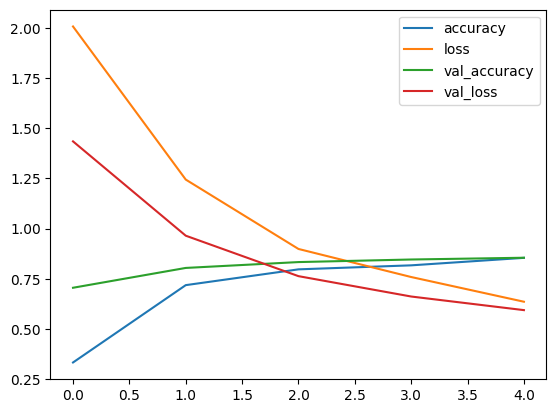

In [10]:
pd.DataFrame(history_1.history).plot()

In [11]:
# Create dataset 

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
new_train_ds = tf.keras.utils.image_dataset_from_directory(
    "../03_tensorflow_neural_network_classification/data/10_food_classes_all_data/train/", 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode="categorical", 
    shuffle=True, 
    seed=42
)

new_test_ds = tf.keras.utils.image_dataset_from_directory(
    "../03_tensorflow_neural_network_classification/data/10_food_classes_all_data/test/", 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode="categorical", 
    shuffle=True, 
    seed=42
)

class_names = new_train_ds.class_names

new_test_ds = new_test_ds.cache().prefetch(tf.data.AUTOTUNE) 
new_train_ds = new_train_ds.cache().prefetch(tf.data.AUTOTUNE)

print(class_names)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [12]:
model_3 = build_efficientv2_model(variant="B0", 
                                   num_classess=len(class_names))

history_3 = model_2.fit(
    new_train_ds, 
    validation_data=new_test_ds, 
    epochs=5, 
    callbacks=[create_tensorboard_callback(dir_name="logs/exercises", experiment_name="EfficientNetV2B0")], 
    verbose=1
)

NameError: name 'model_2' is not defined

In [ ]:
def plot_model_loss_accuracy(history): 
    metrics = pd.DataFrame(history.history) 
    plt.figure(figsize=(7, 5)) 
    ## Plot loss ve val_loss 
    plt.plot(metrics['loss'], label="Training Loss")
    plt.plot(metrics['val_loss'], label="Validation Loss") 
    plt.xlabel("Epochs") 
    plt.ylabel("Loss")
    plt.legend()

    plt.figure(figsize=(7, 5)) 
    ## Plot accuracy ve val_accuracy
    plt.plot(metrics['accuracy'], label="Training accuracy")
    plt.plot(metrics['val_accuracy'], label="Validation val_accuracy") 
    plt.xlabel("Epochs") 
    plt.ylabel("Accuracy")
    plt.legend() 
    plt.show()

In [ ]:
plot_model_loss_accuracy(history_3)

In [ ]:
def build_resnet_model(img_size=IMG_SIZE, 
                       num_classes=len(class_names), 
                       lr = 1e-3): 
    base = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", 
        input_shape=IMG_SIZE+(3,),
        pooling="avg"
    )

    base.trainable=False 

    inputs = keras.Input(shape=IMG_SIZE+(3,)) 
    x = keras.applications.resnet_v2.preprocess_input(inputs) 
    x= base(x, training=False) 
    x = keras.layers.Dropout(0.2)(x) 
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name="ResNet50V2")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]    
    )
    return model

In [ ]:
model_resnet50v2 = build_resnet_model()

In [ ]:
model_resnet50v2.summary()

In [ ]:
history_resnet = model_resnet50v2.fit(
    new_train_ds, 
    validation_data=new_test_ds, 
    epochs=5, 
    callbacks=[create_tensorboard_callback(dir_name="logs/exercises", experiment_name="resnet50v2")], 
    verbose=1
)

In [ ]:
plot_model_loss_accuracy(history_resnet)

In [ ]:
## Definitely read : https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49